# Portfolio Optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from returns import Returns
from risks import Risks
from metrics import Metrics
from optimizer import Optimizer


## Import data

In [2]:
df_raw_all = pd.read_hdf("dow30_full_selected.h5")


In [3]:
df_raw_prices = df_raw_all[["date", "tic", "close"]].rename(columns={"close": "price"})


In [4]:
df_prices = df_raw_prices.pivot(index="date", columns="tic", values="price").loc[
    "2009-01-02":"2020-01-01"
]


In [5]:
df_prices.index = pd.to_datetime(df_prices.index)

## Solve and check summary

In [6]:
def construct_portfolio(
    df_prices: pd.DataFrame,
    rfr: float,
    freq: str = "monthly",
    objective: str = "quadratic_utility",
    constraints: list = [],
    objective_kwargs: dict = {},
    constraint_kwargs: list = [],
) -> tuple:
    """
    Global function to solve portfolio problem

    Parameters
    ----------
    df_prices : pd.DataFrame
        DataFrame containing asset prices
    rfr : float
        Risk free rate of return
    freq : str, optional
        Frequency of portfolio rebalancing, by default "monthly"
    objective : str, optional
        Objective of investor, by default "quadratic_utility"
    constraint : list, optional
        Constraints of investor

    Returns
    -------
    tuple
        Tuple of dicts: weights and portfolio metrics
    """
    # Convert to same time scale
    if freq == "monthly":
        t = 12
        ts = 20
    elif freq == "yearly":
        t = 1
        ts = 252
    elif freq == "daily":
        t = 252
        ts = 1

    # Input data
    returns_generator = Returns(df_prices)
    df_returns = returns_generator.compute_returns(method="daily")
    # rfr_daily = ((1 + rfr) ** (1 / 252)) - 1
    # rfr_effective = ((1 + rfr) ** (1 / t)) - 1
    # df_returns["RF"] = rfr_daily
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=ts
    )
    # mu_return_geom["RF"] = rfr_effective
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=ts)

    # Construct optimizer
    portfolio_problem = Optimizer(
        mu_return_geom, cov_matrix, asset_names=list(mu_return_geom.index)
    )

    # print(portfolio_problem.objective_options())
    # print(portfolio_problem.constraint_options())

    portfolio_problem.clear_problem()
    portfolio_problem.add_objective(objective, **objective_kwargs)
    for c, kwarg in zip(constraints, constraint_kwargs):
        portfolio_problem.add_constraint(c, **kwarg)

    # Solve problem
    portfolio_problem.solve()

    return portfolio_problem.summary(rfr=0.01 / 12)


## Solve min. variance

In [7]:
begin = pd.to_datetime("2017-09-01")
end = pd.to_datetime("2018-09-01")
n_trades = 16


In [8]:
res_minvar = []
rtrn_minvar = []
np.random.seed(42)
for i in range(n_trades):
    w_minvar, perf_minvar = construct_portfolio(
        df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)],
        0.0000,
        "monthly",
        "min_variance",
        ["weight"],
        {},
        [{"weight_bound": (-1, 1), "sum": 1}],
    )
    print(perf_minvar)
    res_minvar.append(w_minvar)
    rtrn_minvar.append(perf_minvar["Expected return"])
df_weights_minvar = pd.DataFrame(res_minvar)


{'Expected return': 0.013, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.043, 'Correlation': 0.5167, 'Sharpe Ratio': 0.283}
{'Expected return': 0.0098, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.0421, 'Correlation': 0.5782, 'Sharpe Ratio': 0.2136}
{'Expected return': -0.0051, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0438, 'Correlation': 0.5408, 'Sharpe Ratio': -0.1354}
{'Expected return': -0.0039, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0456, 'Correlation': 0.5939, 'Sharpe Ratio': -0.1031}
{'Expected return': -0.0098, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0501, 'Correlation': 0.5982, 'Sharpe Ratio': -0.2118}
{'Expected return': -0.0119, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0498, 'Correlation': 0.6221, 'Sharpe Ratio': -0.255}
{'Expected return': 0.0009, 'Sum': 1.0001, 'Num. holdings': 4, 'Volatility': 0.0448, 'Correlation': 0.6198, 'Sharpe Ratio': 0.0014}
{'Expected return': 0.0065, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0418, 'Corr

c:\Users\simon.therien\OneDrive\Portfolio optim\risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


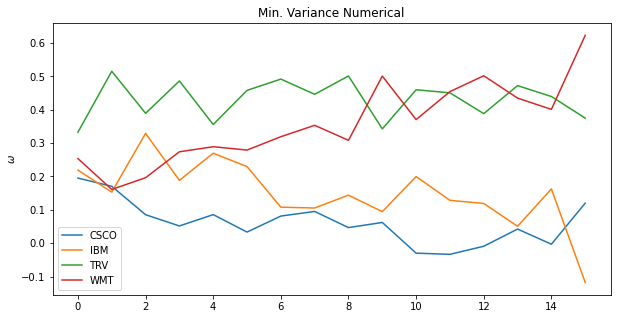

In [9]:
df_weights_minvar.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Min. Variance Numerical")
plt.show()


## Exact solution min. variance

In [10]:
res_gmv = []
for i in range(n_trades):
    returns_generator = Returns(df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)])
    df_returns = returns_generator.compute_returns(method="daily")
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=20
    )
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=20)

    inverse_cov_df = np.linalg.pinv(cov_matrix)

    n_assets = len(cov_matrix)

    numerator = np.matmul(np.ones(n_assets).T, inverse_cov_df)
    denominator = np.matmul(
        np.ones(n_assets).T, (np.matmul(inverse_cov_df, np.ones(n_assets)))
    )
    gmv_w = numerator / denominator
    res_gmv.append(gmv_w)
df_weights_gmv = pd.DataFrame(res_gmv, columns=cov_matrix.columns)


c:\Users\simon.therien\OneDrive\Portfolio optim\risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


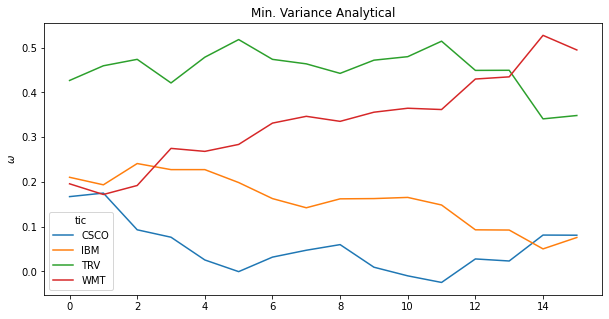

In [11]:
df_weights_gmv.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Min. Variance Analytical")
plt.show()


## Compare min. variance

In [12]:
df_weights_gmv.mean(axis=0)


tic
CSCO    0.053988
IBM     0.159603
TRV     0.450818
WMT     0.335591
dtype: float64

In [13]:
df_weights_minvar.mean(axis=0)


CSCO    0.062081
IBM     0.148938
TRV     0.431519
WMT     0.357469
dtype: float64

In [14]:
init_w = 1000000
cum_w_minvar = init_w * np.cumprod(1 + np.array(rtrn_minvar))
print("Final wealth ", cum_w_minvar[-1])


Final wealth  1088634.8527825337


## Solve quadratic

In [15]:
res_qu = []
rtrn_qu = []
np.random.seed(42)
for i in range(n_trades):
    w_qu, perf_qu = construct_portfolio(
        df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)],
        0.0000,
        "monthly",
        "quadratic_utility",
        ["weight"],
        {"aversion": 8},
        [{"weight_bound": (-4, 4), "sum": 1}],
    )
    print(perf_qu)
    res_qu.append(w_qu)
    rtrn_qu.append(perf_qu["Expected return"])
df_weights_qu = pd.DataFrame(res_qu)


{'Expected return': 0.0447, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0771, 'Correlation': 1.5865, 'Sharpe Ratio': 0.5693}
{'Expected return': 0.0395, 'Sum': 1.0001, 'Num. holdings': 4, 'Volatility': 0.0737, 'Correlation': 1.4721, 'Sharpe Ratio': 0.5241}
{'Expected return': 0.0579, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.0978, 'Correlation': 2.237, 'Sharpe Ratio': 0.5836}
{'Expected return': 0.0368, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.0846, 'Correlation': 1.5888, 'Sharpe Ratio': 0.4247}
{'Expected return': 0.0209, 'Sum': 1.0001, 'Num. holdings': 4, 'Volatility': 0.0797, 'Correlation': 1.2975, 'Sharpe Ratio': 0.2513}
{'Expected return': 0.0107, 'Sum': 0.9999, 'Num. holdings': 4, 'Volatility': 0.0734, 'Correlation': 0.9691, 'Sharpe Ratio': 0.1345}
{'Expected return': 0.0174, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0648, 'Correlation': 1.0014, 'Sharpe Ratio': 0.2566}
{'Expected return': 0.0333, 'Sum': 1.0, 'Num. holdings': 4, 'Volatility': 0.0726, '

c:\Users\simon.therien\OneDrive\Portfolio optim\risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


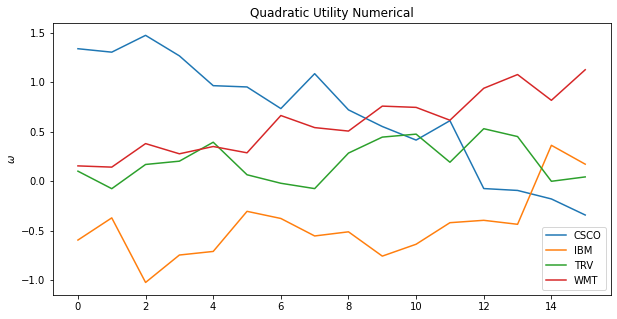

In [16]:
df_weights_qu.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Quadratic Utility Numerical")
plt.show()


## Exact solution quadratic

In [17]:
res_quadratic = []
for i in range(n_trades):
    returns_generator = Returns(df_prices[begin + pd.DateOffset(months=i): end + pd.DateOffset(months=i)])
    df_returns = returns_generator.compute_returns(method="daily")
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=20
    )
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=20)


    inverse_cov_df = np.linalg.pinv(cov_matrix)

    n_assets = len(cov_matrix)

    aversion = 8
    numerator_mvp = np.matmul(np.ones(n_assets).T, inverse_cov_df)
    denominator_mvp = np.matmul(
        np.ones(n_assets).T, (np.matmul(inverse_cov_df, np.ones(n_assets)))
    )
    mvp_w = numerator_mvp / denominator_mvp
    numerator_tangency = np.matmul(mu_return_geom.T, inverse_cov_df)
    denominator_tangency = np.matmul(
        np.ones(n_assets).T, (np.matmul(inverse_cov_df, mu_return_geom))
    )
    tangency_w = numerator_tangency / denominator_tangency
    quadratic_w = mvp_w + (1 / aversion) * denominator_tangency * (tangency_w - mvp_w)
    res_quadratic.append(quadratic_w)
df_weights_quadratic = pd.DataFrame(res_quadratic, columns=cov_matrix.columns)


c:\Users\simon.therien\OneDrive\Portfolio optim\risks.py:80: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


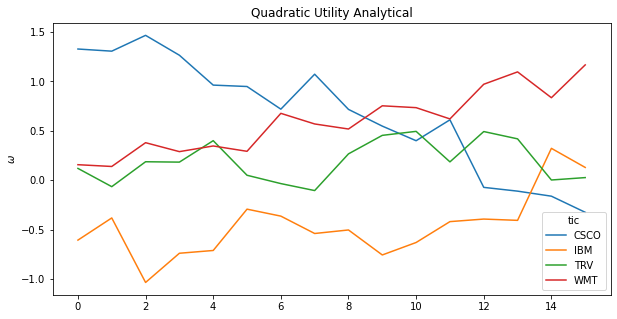

In [18]:
df_weights_quadratic.plot.line(figsize=(10, 5))
plt.ylabel("$\omega$")
plt.title("Quadratic Utility Analytical")
plt.show()


## Compare quadratic

In [19]:
# Numerical
df_weights_qu.mean(axis=0)


CSCO    0.671050
IBM    -0.456600
TRV     0.198819
WMT     0.586712
dtype: float64

In [20]:
# Analytical
df_weights_quadratic.mean(axis=0)


tic
CSCO    0.667548
IBM    -0.457362
TRV     0.192735
WMT     0.597079
dtype: float64

In [21]:
cum_w_qu = init_w * np.cumprod(1 + np.array(rtrn_qu))
print("Final wealth ", cum_w_qu[-1])


Final wealth  1559968.7118462971
